# 1 Preprocessing
## 1.1 Data Cleaning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First we import datasets and examine the data condition.

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

file_path_SLQ = "/content/drive/MyDrive/WIA1007_Project/SLQ_L.xpt"
file_path_PAQ = "/content/drive/MyDrive/WIA1007_Project/PAQ_L.xpt"

dfSL = pd.read_sas(file_path_SLQ)
dfPA = pd.read_sas(file_path_PAQ)

print('-----------------Sleep-----------')
dfSL.info()
print('===================Activity==================')
dfPA.info()

-----------------Sleep-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8501 entries, 0 to 8500
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    8501 non-null   float64
 1   SLQ300  8501 non-null   object 
 2   SLQ310  8501 non-null   object 
 3   SLD012  8388 non-null   float64
 4   SLQ320  8501 non-null   object 
 5   SLQ330  8501 non-null   object 
 6   SLD013  8387 non-null   float64
dtypes: float64(3), object(4)
memory usage: 465.0+ KB
===================Activity==================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8153 entries, 0 to 8152
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SEQN     8153 non-null   float64
 1   PAD790Q  8135 non-null   float64
 2   PAD790U  8153 non-null   object 
 3   PAD800   6390 non-null   float64
 4   PAD810Q  8139 non-null   float64
 5   PAD810U  8153 non-null   object 
 6   PAD820   368

The condition of data is quite well. But there are still something we need to fix:
1. The columns' titles are in CDC code, needed to be converted to human-readable text.
2. A few missing values.
3. Some irrelavant factors are included.

### 1.1.1 ReName

In [150]:
# Sleep data mapping
sleep_rename_dict = {
    'SEQN': 'SEQN',
    'SLQ300': 'usual_sleep_time_weekdays',
    'SLQ310': 'usual_wake_time_weekdays',
    'SLD012': 'sleep_hours_weekdays',
    'SLQ320': 'usual_sleep_time_weekends',
    'SLQ330': 'usual_wake_time_weekends',
    'SLD013': 'sleep_hours_weekends'
}

# Activity data mapping
physical_activity_rename_dict = {
    'SEQN': 'SEQN',
    'PAD790Q': 'frequency_moderate_activity',
    'PAD790U': 'unit_moderate_activity',
    'PAD800': 'minutes_moderate_activity',
    'PAD810Q': 'frequency_vigorous_activity',
    'PAD810U': 'unit_vigorous_activity',
    'PAD820': 'minutes_vigorous_activity',
    'PAD680': 'minutes_sedentary_activity'
}

# function to rename
def rename_columns(df, rename_dict):
    return df.rename(columns=rename_dict)


dfSL = rename_columns(dfSL, sleep_rename_dict)
dfPA = rename_columns(dfPA, physical_activity_rename_dict)

### 1.1.2 Concatenation/Integrating
Usually we clean different dataset repectively and then concatenate them. However, the CDC questionnaire are from the surveyees with the same SEQN, which means the separate datasets are in fact one unitary dataset at first. We concatenate first thus we drop some surveyees lack of columns we care about, alleviating the work amount of data cleaning.

In [151]:
#Merge the dataset
df_merged = pd.merge(dfPA, dfSL, on='SEQN', how='inner')

In [152]:
df_merged.head()

,SEQN,frequency_moderate_activity,unit_moderate_activity,minutes_moderate_activity,frequency_vigorous_activity,unit_vigorous_activity,minutes_vigorous_activity,minutes_sedentary_activity,usual_sleep_time_weekdays,usual_wake_time_weekdays,sleep_hours_weekdays,usual_sleep_time_weekends,usual_wake_time_weekends,sleep_hours_weekends
0,130378.0,3.000000e+00,b'W',45.0,3.000000e+00,b'W',45.0,360.0,b'21:30',b'07:00',9.5,b'00:00',b'09:00',9.0
1,130379.0,4.000000e+00,b'W',45.0,3.000000e+00,b'W',45.0,480.0,b'21:00',b'06:00',9.0,b'21:00',b'06:00',9.0
2,130380.0,1.000000e+00,b'W',20.0,5.397605e-79,b'',NaN,240.0,b'00:00',b'08:00',8.0,b'00:00',b'09:00',9.0
3,130384.0,5.397605e-79,b'',NaN,5.397605e-79,b'',NaN,60.0,b'21:30',b'05:00',7.5,b'23:00',b'07:00',8.0
4,130385.0,1.000000e+00,b'D',90.0,1.000000e+00,b'W',60.0,180.0,b'22:05',b'06:15',8.0,b'22:05',b'06:15',8.0


### 1.1.3 Transformation & Reduction
Some columns are relevant to our questions. For some variables, multiple columns are used to present one info. Here we fix these issues.

In [153]:
# There are various Units for frequency in PA
for dictName in {"unit_moderate_activity","unit_vigorous_activity"}:
  print("\nUnique Category for "+dictName)
  print(df_merged[dictName].unique())


Unique Category for unit_moderate_activity
[b'W' b'' b'D' b'M' b'Y']

Unique Category for unit_vigorous_activity
[b'W' b'' b'M' b'D' b'Y']


In [154]:
# converting all the frequency into PER WEEK
def convert_to_weekly_frequency(df_merged):
    # converting function/formula
    def convert_frequency(freq, unit):
        # Invalid value handling
        if pd.isna(freq) or freq in [7777, 9999]:
            return np.nan

        unit_str = unit.decode('utf-8') if isinstance(unit, bytes) else str(unit)
        # if no unit, speculate it by the rule provided by CDC
        if pd.isna(unit_str) or unit_str == '':
            if freq <= 4:
                unit_str = 'D'
            elif freq <= 28:
                unit_str = 'W'
            elif freq <= 31:
                unit_str = 'M'
            elif freq <= 365:
                unit_str = 'Y'
            else:
                return np.nan

        # calculate valid rows
        if unit_str == 'D':
            return freq * 7
        elif unit_str == 'W':
            return freq
        elif unit_str == 'M':
            return freq * 4.345
        elif unit_str == 'Y':
            return freq / 52
        else:
            return np.nan

    # handle the moderate
    df_merged['moderate_activity_weekly'] = df_merged.apply(
        lambda row: convert_frequency(row['frequency_moderate_activity'],row['unit_moderate_activity']),axis=1
    )

    # handle the vigorous
    df_merged['vigorous_activity_weekly'] = df_merged.apply(
        lambda row: convert_frequency(row['frequency_vigorous_activity'],row['unit_vigorous_activity']),axis=1
    )

    # drop the old columns
    columns_to_drop = ['frequency_moderate_activity', 'unit_moderate_activity','frequency_vigorous_activity', 'unit_vigorous_activity']

    existing_columns = [col for col in columns_to_drop if col in df_merged.columns]
    df_merged = df_merged.drop(columns=existing_columns)

    return df_merged

df_merged = convert_to_weekly_frequency(df_merged)

In [155]:
# Check the result
df_merged.head()

,SEQN,minutes_moderate_activity,minutes_vigorous_activity,minutes_sedentary_activity,usual_sleep_time_weekdays,usual_wake_time_weekdays,sleep_hours_weekdays,usual_sleep_time_weekends,usual_wake_time_weekends,sleep_hours_weekends,moderate_activity_weekly,vigorous_activity_weekly
0,130378.0,45.0,45.0,360.0,b'21:30',b'07:00',9.5,b'00:00',b'09:00',9.0,3.000000e+00,3.000000e+00
1,130379.0,45.0,45.0,480.0,b'21:00',b'06:00',9.0,b'21:00',b'06:00',9.0,4.000000e+00,3.000000e+00
2,130380.0,20.0,NaN,240.0,b'00:00',b'08:00',8.0,b'00:00',b'09:00',9.0,1.000000e+00,3.778324e-78
3,130384.0,NaN,NaN,60.0,b'21:30',b'05:00',7.5,b'23:00',b'07:00',8.0,3.778324e-78,3.778324e-78
4,130385.0,90.0,60.0,180.0,b'22:05',b'06:15',8.0,b'22:05',b'06:15',8.0,7.000000e+00,1.000000e+00


Drop irrelevant colums

In [156]:
columns_to_drop = ['usual_sleep_time_weekdays', 'usual_wake_time_weekdays','usual_sleep_time_weekends', 'usual_wake_time_weekends']
existing_columns = [col for col in columns_to_drop if col in df_merged.columns]
df_merged = df_merged.drop(columns=existing_columns)

In [157]:
df_merged.head()

,SEQN,minutes_moderate_activity,minutes_vigorous_activity,minutes_sedentary_activity,sleep_hours_weekdays,sleep_hours_weekends,moderate_activity_weekly,vigorous_activity_weekly
0,130378.0,45.0,45.0,360.0,9.5,9.0,3.000000e+00,3.000000e+00
1,130379.0,45.0,45.0,480.0,9.0,9.0,4.000000e+00,3.000000e+00
2,130380.0,20.0,NaN,240.0,8.0,9.0,1.000000e+00,3.778324e-78
3,130384.0,NaN,NaN,60.0,7.5,8.0,3.778324e-78,3.778324e-78
4,130385.0,90.0,60.0,180.0,8.0,8.0,7.000000e+00,1.000000e+00


There are some extremely small numbers which supposed to be errors. Replace them with 0 (notice that cells with extremely small numbers are usually with some NaN in the same line, making it be 0 reasonable).

In [158]:
df_merged = df_merged.map(lambda x: 0 if isinstance(x, (int, float)) and abs(x) < 1e-5 else x)

In [159]:
df_merged['minutes_sedentary_activity'] = df_merged['minutes_sedentary_activity'].replace([7777, 9999], np.nan)

In [160]:
df_merged.head()

,SEQN,minutes_moderate_activity,minutes_vigorous_activity,minutes_sedentary_activity,sleep_hours_weekdays,sleep_hours_weekends,moderate_activity_weekly,vigorous_activity_weekly
0,130378.0,45.0,45.0,360.0,9.5,9.0,3.0,3.0
1,130379.0,45.0,45.0,480.0,9.0,9.0,4.0,3.0
2,130380.0,20.0,NaN,240.0,8.0,9.0,1.0,0.0
3,130384.0,NaN,NaN,60.0,7.5,8.0,0.0,0.0
4,130385.0,90.0,60.0,180.0,8.0,8.0,7.0,1.0


In [161]:
activity_pairs = [
    ('minutes_moderate_activity', 'moderate_activity_weekly'),
    ('minutes_vigorous_activity', 'vigorous_activity_weekly')
]

for minutes, weekly in activity_pairs:
    # time = 0, then frequency should be 0
    df_merged.loc[df_merged[minutes] == 0, weekly] = 0
    # freq = 0, then time should be 0
    df_merged.loc[df_merged[weekly] == 0, minutes] = 0
    # when one of it is 0, the other is NA, the NA one is 0(the surveyee was confused so leaving it empty)
    df_merged.loc[(df_merged[minutes].isna()) & (df_merged[weekly] == 0), minutes] = 0
    df_merged.loc[(df_merged[weekly].isna()) & (df_merged[minutes] == 0), weekly] = 0

In [162]:
df_merged.head()

,SEQN,minutes_moderate_activity,minutes_vigorous_activity,minutes_sedentary_activity,sleep_hours_weekdays,sleep_hours_weekends,moderate_activity_weekly,vigorous_activity_weekly
0,130378.0,45.0,45.0,360.0,9.5,9.0,3.0,3.0
1,130379.0,45.0,45.0,480.0,9.0,9.0,4.0,3.0
2,130380.0,20.0,0.0,240.0,8.0,9.0,1.0,0.0
3,130384.0,0.0,0.0,60.0,7.5,8.0,0.0,0.0
4,130385.0,90.0,60.0,180.0,8.0,8.0,7.0,1.0


### 1.1.4 Filling the missing Values
Many people do not exercise at all, and they may feel embarrassed when asked about it. Thus they tend to leaving the question empty or choose "Do not want answer" when answering the questionnaire. Thus, we will apply mode(which is definitely 0) to fill the activity-related NA. As to the sleeping pattern which is usually be in good Gaussian Distribution, we apply median to fill the NA.

In [163]:
# sleep: yes! sedentary also is considered as sleep logically
sleep_colums = ["sleep_hours_weekdays","sleep_hours_weekends",'minutes_sedentary_activity']
activity_colums = ['minutes_moderate_activity', 'moderate_activity_weekly','minutes_vigorous_activity', 'vigorous_activity_weekly']

for col in sleep_colums:
  df_merged[col] = df_merged[col].fillna(df_merged[col].median())

for col in activity_colums:
  df_merged[col] = df_merged[col].fillna(df_merged[col].mode()[0])

## 1.2 Reduction
The activity-related variables do not tell the weekday or weekends, thus if we focusing on their relations, the sleep hours should not be divided into two parts either.

In [164]:
# Conbine sleep time into weekly average
def convert_to_weekly_sleep(df_merged):
    # converting function/formula
    def convert_sleep(weekdays,weekends):
      return (weekdays*5+weekends*2)/7

    # perform caculation
    df_merged['sleep_hours_weekly_aver'] = df_merged.apply(
        lambda row: convert_sleep(row['sleep_hours_weekdays'],row['sleep_hours_weekends']),axis=1
    )

    # drop the old columns
    columns_to_drop = ['sleep_hours_weekdays','sleep_hours_weekends']
    existing_columns = [col for col in columns_to_drop if col in df_merged.columns]
    df_merged = df_merged.drop(columns=existing_columns)

    return df_merged

df_merged = convert_to_weekly_sleep(df_merged)

In [165]:
# sorry for forget this...
df_merged = df_merged.drop_duplicates()

# 2 EDA
Hypothesis:
1. The excercise helps sleeping, but over-exercise will do the opposite
2. The frequency matters more. Exercising regularly helps people more than exercising suddenly with huge intensity.
## 2.1 Bivariate Correlation
### 2.1.1 Linear Correlation

In [166]:
df_num = df_merged.drop(columns=['SEQN'])

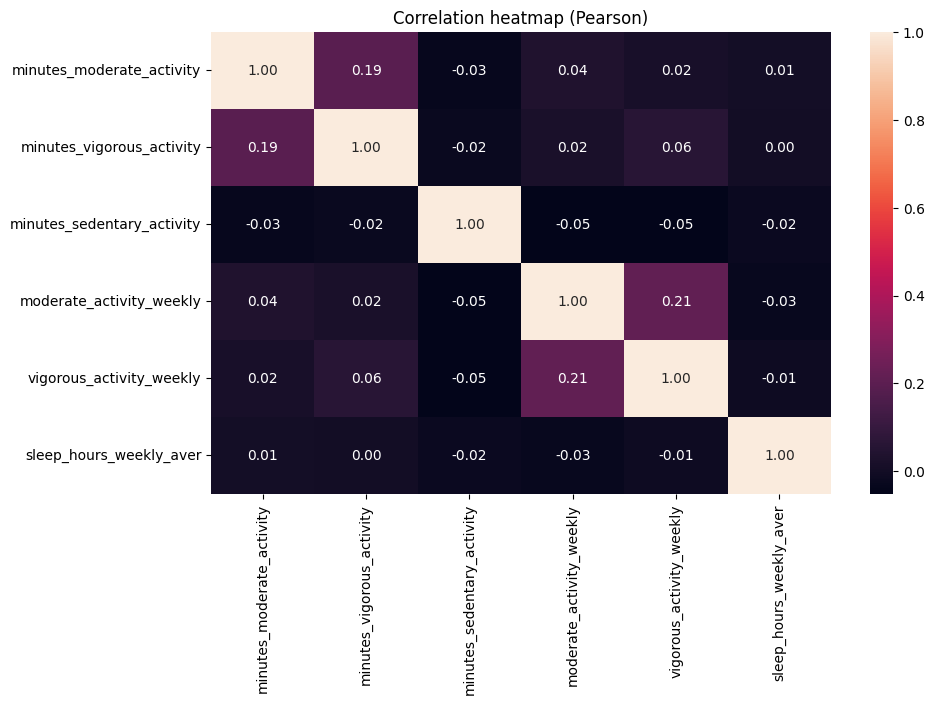

,minutes_moderate_activity,minutes_vigorous_activity,minutes_sedentary_activity,moderate_activity_weekly,vigorous_activity_weekly,sleep_hours_weekly_aver
minutes_moderate_activity,1.000000,0.194166,-0.032175,0.037542,0.016565,0.005559
minutes_vigorous_activity,0.194166,1.000000,-0.022808,0.018484,0.060145,0.001379
minutes_sedentary_activity,-0.032175,-0.022808,1.000000,-0.051528,-0.048420,-0.020625
moderate_activity_weekly,0.037542,0.018484,-0.051528,1.000000,0.212985,-0.028388
vigorous_activity_weekly,0.016565,0.060145,-0.048420,0.212985,1.000000,-0.011569
sleep_hours_weekly_aver,0.005559,0.001379,-0.020625,-0.028388,-0.011569,1.000000


In [167]:
# Correlation matrix (Pearson)
corr = df_num.corr(numeric_only=True)

# Creates a figure and draws a heatmap of the correlation matrix.
# annot=True prints the correlation values inside each cell.
# fmt=".2f" shows values with 2 decimal places.
# The heatmap makes it easy to spot strong relationships quickly.
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation heatmap (Pearson)")
plt.show()

# Displays the correlation matrix as a table as well (useful if you want exact values or to copy them).
corr

Unluckily, almost no linear correlation could be discovered in the columns.
### 2.1.2 Non-linear Relationship

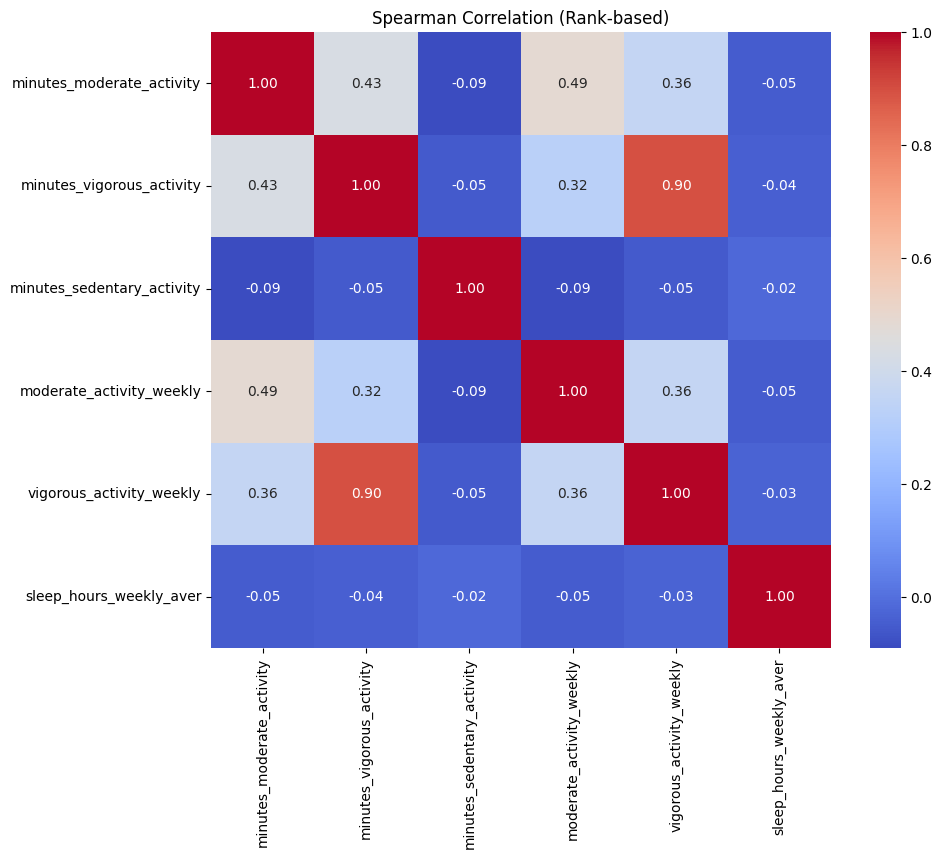

/tmp/ipython-input-552139014.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_series.values, y=mi_series.index, palette='viridis')


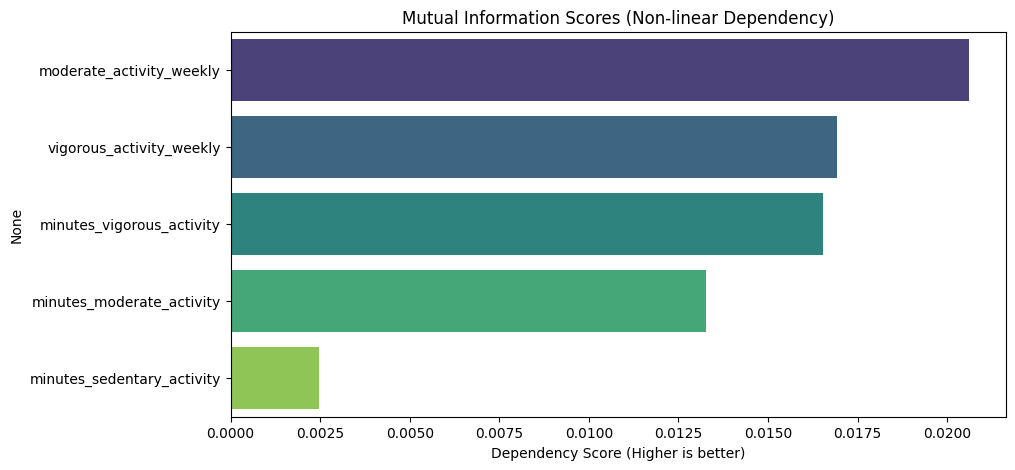

/tmp/ipython-input-552139014.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='magma')


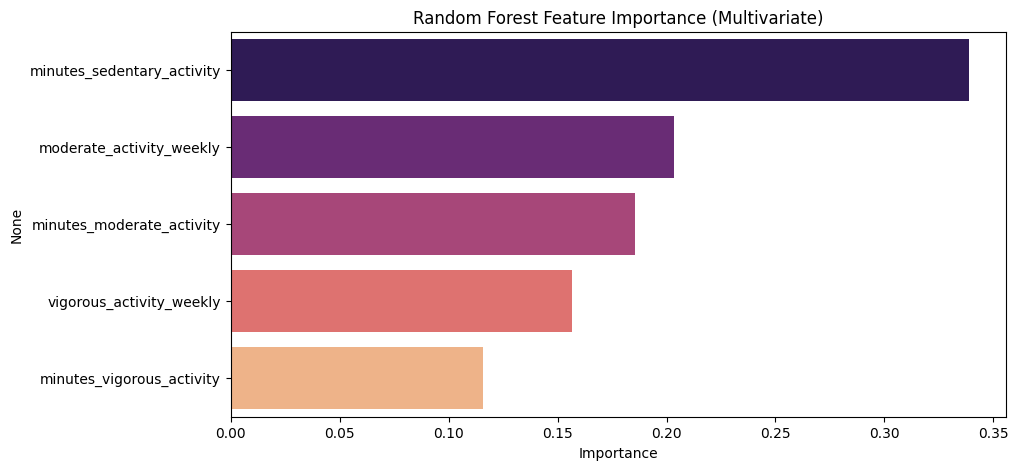

In [168]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

features = [
    'minutes_moderate_activity',
    'moderate_activity_weekly',
    'minutes_vigorous_activity',
    'vigorous_activity_weekly',
    'minutes_sedentary_activity'
]
target = 'sleep_hours_weekly_aver'

X = df_num[features]
y = df_num[target]


# 1. Spearman Correlation
plt.figure(figsize=(10, 8))

sns.heatmap(df_num.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation (Rank-based)")
plt.show()


# 2. Mutual Information
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=mi_series.values, y=mi_series.index, palette='viridis')
plt.title("Mutual Information Scores (Non-linear Dependency)")
plt.xlabel("Dependency Score (Higher is better)")
plt.show()


# 3.Random Forest

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X, y)

# Importances
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title("Random Forest Feature Importance (Multivariate)")
plt.xlabel("Importance")
plt.show()

/tmp/ipython-input-1560337428.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_num.groupby('sedentary_group')['sleep_hours_weekly_aver'].mean())


sedentary_group
Low          7.881558
Medium       7.945557
High         7.932229
Very High    7.842453
Name: sleep_hours_weekly_aver, dtype: float64


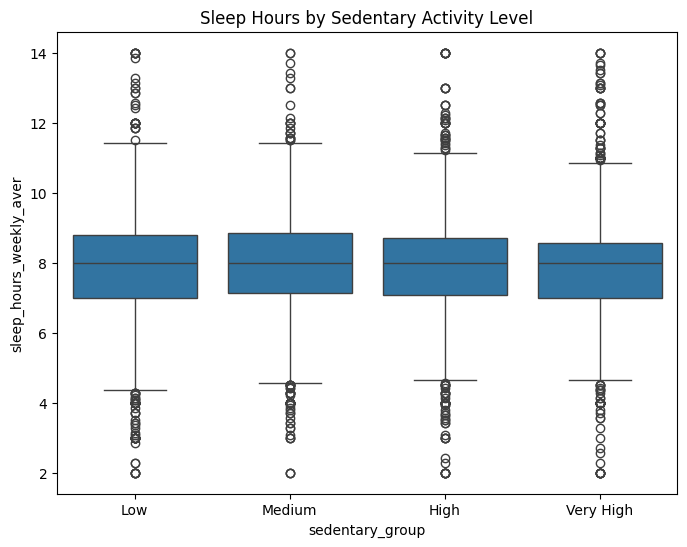

In [169]:
# Label people in to 4 groups according to 'minutes_sedentary_activity'
df_num['sedentary_group'] = pd.qcut(df_num['minutes_sedentary_activity'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# see the mean of different groups
print(df_num.groupby('sedentary_group')['sleep_hours_weekly_aver'].mean())

# Boxplot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.boxplot(x='sedentary_group', y='sleep_hours_weekly_aver', data=df_num)
plt.title("Sleep Hours by Sedentary Activity Level")
plt.show()

The sleep is proved to have relation with sedentary activity level: the highest and lowest groups sleep shorter than the medium groups. However, the differences is extremely small: less than 5-minute difference.

# 3 Reflection
Contrary to popular belief, our analysis revealed surprisingly weak correlations between physical activity and sleep duration (r < 0.1). This counterintuitive finding highlights the complexity of human behavior patterns. The relationship is likely obscured by numerous confounding factors—age, health status, and socioeconomic conditions simultaneously influence both exercise habits and sleep patterns. Futhermore, while exercise and sleep are undoubtedly interconnected, their relationship appears more nuanced than a simple linear association, potentially involving threshold effects and individual variations that cross-sectional data cannot capture.
Thus we try simulate Longitudinal/Panel Analysis, through clustering similar groups of people, and see if the exercise do effect on their sleep among clusters.

# 1 Preprocessing
Upon this try, we will focusing on people who are similar to students major in Computer Science: aging 18 to 25, long sedentary and highly educated people. We will look into their sleep and exercise pattern to discover the underlying relationship.

In [170]:
base_path = "/content/drive/MyDrive/WIA1007_Project/"
file_path_DEMO = base_path + "DEMO_L.xpt"
file_path_BMX = base_path + "BMX_L.xpt"
file_path_DPQ = base_path + "DPQ_L.xpt"

df_demo = pd.read_sas(file_path_DEMO)
df_bmi = pd.read_sas(file_path_BMX)
df_dpq = pd.read_sas(file_path_DPQ)
df_demo_clean = df_demo[['SEQN', 'RIDAGEYR', 'RIAGENDR', 'DMDEDUC2']]
df_bmi_clean = df_bmi[['SEQN', 'BMXBMI']]
df_dpq_clean = df_dpq[['SEQN', 'DPQ020']]

df_final = df_merged.merge(df_demo_clean, on='SEQN', how='inner')
df_final = df_final.merge(df_bmi_clean, on='SEQN', how='inner')
df_final = df_final.merge(df_dpq_clean, on='SEQN', how='inner')


In [171]:
df_final['DPQ020'] = df_final['DPQ020'].replace([7, 9], np.nan)

In [172]:
df_final.head()

,SEQN,minutes_moderate_activity,minutes_vigorous_activity,minutes_sedentary_activity,moderate_activity_weekly,vigorous_activity_weekly,sleep_hours_weekly_aver,RIDAGEYR,RIAGENDR,DMDEDUC2,BMXBMI,DPQ020
0,130378.0,45.0,45.0,360.0,3.0,3.000,9.357143,43.0,1.0,5.0,27.0,NaN
1,130379.0,45.0,45.0,480.0,4.0,3.000,9.000000,66.0,1.0,5.0,33.5,5.397605e-79
2,130380.0,20.0,0.0,240.0,1.0,0.000,8.285714,44.0,2.0,3.0,29.7,5.397605e-79
3,130386.0,30.0,30.0,180.0,1.0,4.345,7.642857,34.0,1.0,4.0,30.2,5.397605e-79
4,130387.0,0.0,0.0,1200.0,0.0,0.000,3.571429,68.0,2.0,5.0,42.6,5.397605e-79


Male =1, Female = 2  
Colleage & Graduate = 4 & 5

In [173]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6337 entries, 0 to 6336
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SEQN                        6337 non-null   float64
 1   minutes_moderate_activity   6337 non-null   float64
 2   minutes_vigorous_activity   6337 non-null   float64
 3   minutes_sedentary_activity  6337 non-null   float64
 4   moderate_activity_weekly    6337 non-null   float64
 5   vigorous_activity_weekly    6337 non-null   float64
 6   sleep_hours_weekly_aver     6337 non-null   float64
 7   RIDAGEYR                    6337 non-null   float64
 8   RIAGENDR                    6337 non-null   float64
 9   DMDEDUC2                    6064 non-null   float64
 10  BMXBMI                      6235 non-null   float64
 11  DPQ020                      5508 non-null   float64
dtypes: float64(12)
memory usage: 594.2 KB


## 1.2 Missing Value

In [174]:
# Median for BMI
df_final['BMXBMI'] = df_final['BMXBMI'].fillna(df_final['BMXBMI'].median())

# Mode for Education
df_final['DMDEDUC2'] = df_final['DMDEDUC2'].fillna(df_final['DMDEDUC2'].mode()[0])

# Depression: NA usually means people don't have such an issue and leave it empty
df_final['DPQ020'] = df_final['DPQ020'].fillna(0)
# Handle extreme small values -- usually computer system error
df_final = df_final.map(lambda x: 0 if isinstance(x, (int, float)) and abs(x) < 1e-5 else x)

In [175]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6337 entries, 0 to 6336
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SEQN                        6337 non-null   float64
 1   minutes_moderate_activity   6337 non-null   float64
 2   minutes_vigorous_activity   6337 non-null   float64
 3   minutes_sedentary_activity  6337 non-null   float64
 4   moderate_activity_weekly    6337 non-null   float64
 5   vigorous_activity_weekly    6337 non-null   float64
 6   sleep_hours_weekly_aver     6337 non-null   float64
 7   RIDAGEYR                    6337 non-null   float64
 8   RIAGENDR                    6337 non-null   float64
 9   DMDEDUC2                    6337 non-null   float64
 10  BMXBMI                      6337 non-null   float64
 11  DPQ020                      6337 non-null   float64
dtypes: float64(12)
memory usage: 594.2 KB


# 2 EDA
## 2.1 Bivariate Correlation
First, let's see if our new columns do effect on sleep more significantly
### 2.1.1 Scatter Diagram

--- 1. Visualizing Relationships (EDA) ---


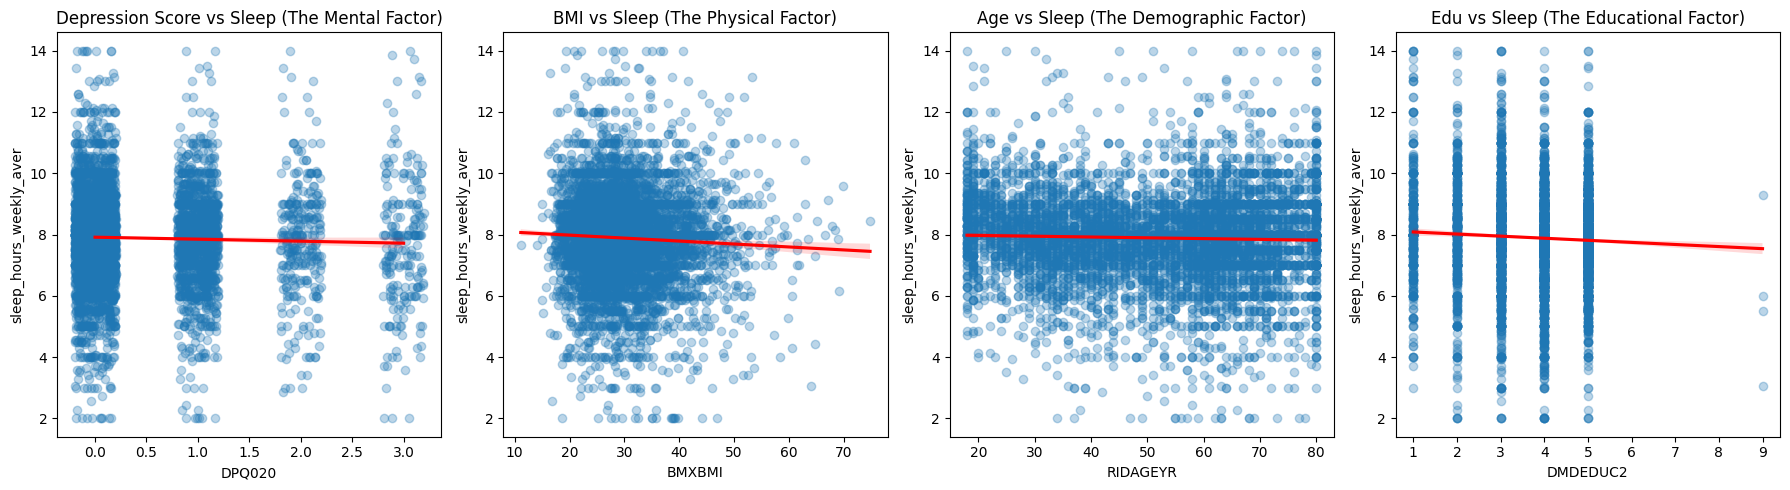

In [176]:
print("--- 1. Visualizing Relationships (EDA) ---")
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Depression
sns.regplot(x='DPQ020', y='sleep_hours_weekly_aver', data=df_final,
            ax=axes[0], x_jitter=0.2, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[0].set_title('Depression Score vs Sleep (The Mental Factor)')

# BMI
sns.regplot(x='BMXBMI', y='sleep_hours_weekly_aver', data=df_final,
            ax=axes[1], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1].set_title('BMI vs Sleep (The Physical Factor)')

# Age
sns.regplot(x='RIDAGEYR', y='sleep_hours_weekly_aver', data=df_final,
            ax=axes[2], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[2].set_title('Age vs Sleep (The Demographic Factor)')

# Education
sns.regplot(x='DMDEDUC2', y='sleep_hours_weekly_aver', data=df_final,
            ax=axes[3], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[3].set_title('Edu vs Sleep (The Educational Factor)')

plt.tight_layout()
plt.show()

A slight declination could be found in all the graphs above. Surprizingly, the most significant one is in the graph Edu VS sleep. It seems like the more you learn, the poorer your sleep is.
### 2.1.2 Histogram

<Axes: >

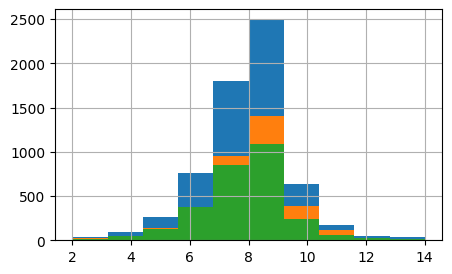

In [177]:
# The following code is copied from Tutorial


# Plot sleep duration histograms (overall and by gender)
# Note: when you plot multiple histograms on the same figure, they may overlap.
# Uncomment one line at a time if you want a cleaner view.

df_final['sleep_hours_weekly_aver'].hist(figsize=(5,3))
df_final[df_final['RIAGENDR']== 2]['sleep_hours_weekly_aver'].hist(figsize=(5,3))
df_final[df_final['RIAGENDR']== 1]['sleep_hours_weekly_aver'].hist(figsize=(5,3))


# df_final['sleep_hours_weekly_aver'].hist(figsize=(5,3))
# plt.title("sleep_hours_weekly_aver Distribution (All)")
# plt.show()

# df_final[df_final['RIAGENDR']== 2]['sleep_hours_weekly_aver'].hist(figsize=(5,3))
# plt.title("sleep_hours_weekly_aver Distribution (Women)")
# plt.show()

# df_final[df_final['RIAGENDR']== 1]['sleep_hours_weekly_aver'].hist(figsize=(5,3))
# plt.title("sleep_hours_weekly_aver Distribution (Men)")
# plt.show()


### 2.1.3 Boxplot

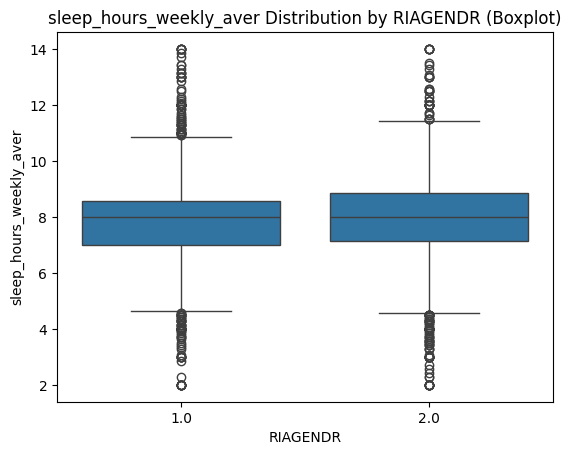

In [178]:
# ------------Box Plot (sleep duration Vs Gender) -------------------------

sns.boxplot(x='RIAGENDR', y='sleep_hours_weekly_aver', data=df_final)
plt.title('sleep_hours_weekly_aver Distribution by RIAGENDR (Boxplot)')
plt.show()

### 2.1.3 Correlation Analysis

#### 2.1.3.1 Pearson Correlation

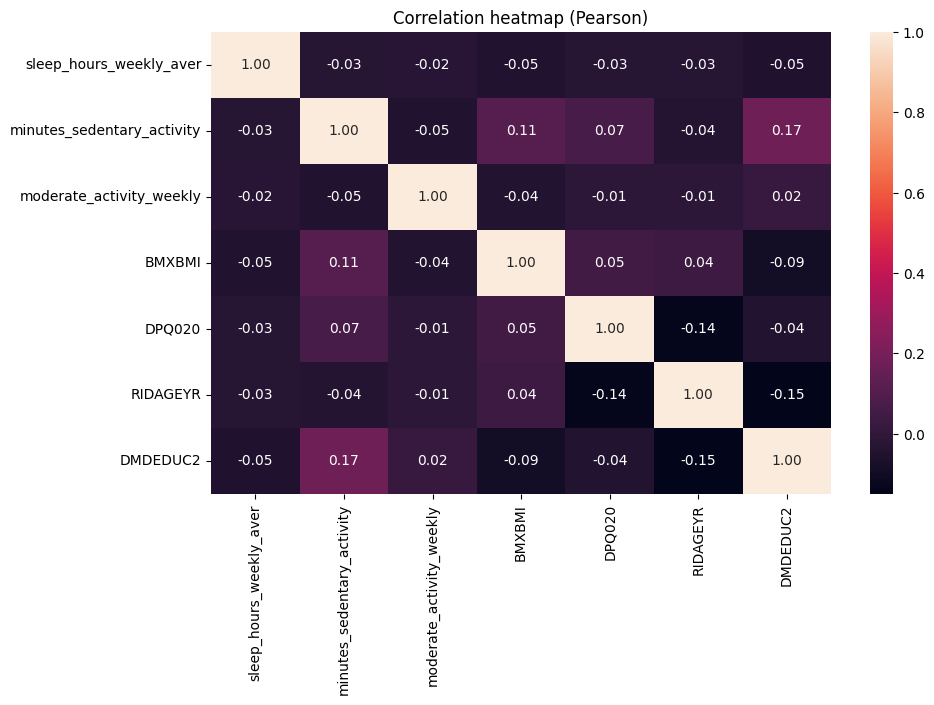

,sleep_hours_weekly_aver,minutes_sedentary_activity,moderate_activity_weekly,BMXBMI,DPQ020,RIDAGEYR,DMDEDUC2
sleep_hours_weekly_aver,1.000000,-0.030471,-0.024353,-0.047463,-0.032137,-0.031873,-0.052278
minutes_sedentary_activity,-0.030471,1.000000,-0.047040,0.110509,0.069550,-0.041077,0.173435
moderate_activity_weekly,-0.024353,-0.047040,1.000000,-0.042884,-0.014150,-0.014058,0.018496
BMXBMI,-0.047463,0.110509,-0.042884,1.000000,0.051501,0.038801,-0.093047
DPQ020,-0.032137,0.069550,-0.014150,0.051501,1.000000,-0.139823,-0.042032
RIDAGEYR,-0.031873,-0.041077,-0.014058,0.038801,-0.139823,1.000000,-0.149725
DMDEDUC2,-0.052278,0.173435,0.018496,-0.093047,-0.042032,-0.149725,1.000000


In [179]:
cols_to_analyze = [
    'sleep_hours_weekly_aver', # Target
    'minutes_sedentary_activity',   # Sedentary
    'moderate_activity_weekly',     #Exercise
    'BMXBMI',         # Body
    'DPQ020',            # Mind
    'RIDAGEYR',       # Age
    'DMDEDUC2'       # Edu
]
df_num = df_final[cols_to_analyze]
# Correlation matrix (Pearson)
corr = df_num.corr(numeric_only=True)

# Creates a figure and draws a heatmap of the correlation matrix.
# annot=True prints the correlation values inside each cell.
# fmt=".2f" shows values with 2 decimal places.
# The heatmap makes it easy to spot strong relationships quickly.
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation heatmap (Pearson)")
plt.show()

# Displays the correlation matrix as a table as well (useful if you want exact values or to copy them).
corr

#### 2.1.3.2 Spearman Correlation

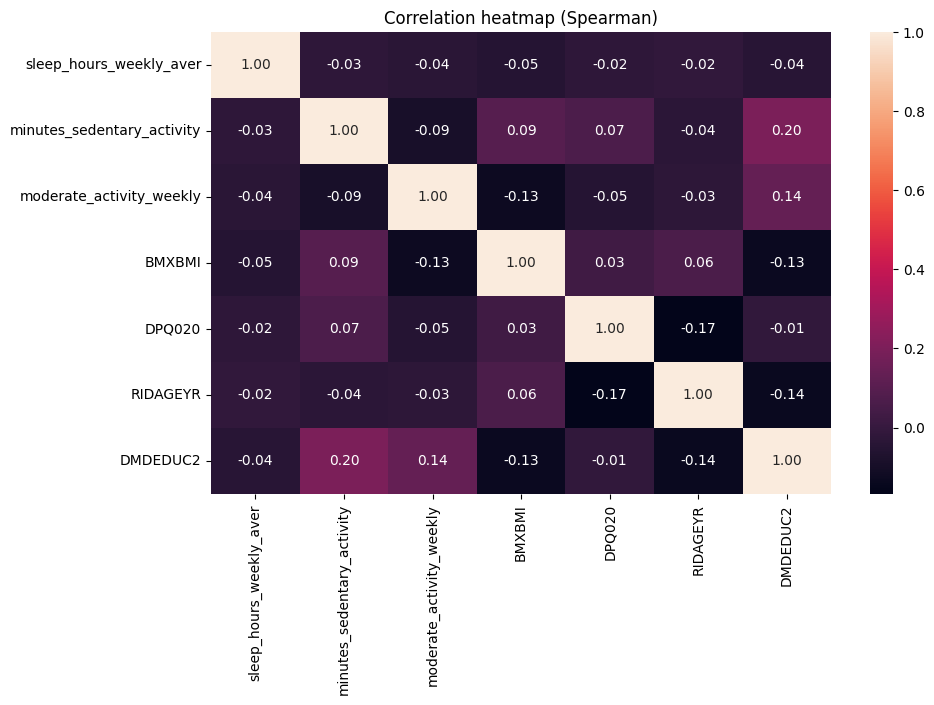

,sleep_hours_weekly_aver,minutes_sedentary_activity,moderate_activity_weekly,BMXBMI,DPQ020,RIDAGEYR,DMDEDUC2
sleep_hours_weekly_aver,1.000000,-0.025439,-0.036857,-0.051319,-0.022627,-0.015955,-0.041947
minutes_sedentary_activity,-0.025439,1.000000,-0.092159,0.094654,0.068320,-0.035307,0.199296
moderate_activity_weekly,-0.036857,-0.092159,1.000000,-0.127292,-0.049277,-0.029516,0.135608
BMXBMI,-0.051319,0.094654,-0.127292,1.000000,0.030209,0.063461,-0.132260
DPQ020,-0.022627,0.068320,-0.049277,0.030209,1.000000,-0.167684,-0.014241
RIDAGEYR,-0.015955,-0.035307,-0.029516,0.063461,-0.167684,1.000000,-0.138808
DMDEDUC2,-0.041947,0.199296,0.135608,-0.132260,-0.014241,-0.138808,1.000000


In [180]:
# Correlation matrix (Spearman)
corr = df_num.corr(method = 'spearman')

# Creates a figure and draws a heatmap of the correlation matrix.
# annot=True prints the correlation values inside each cell.
# fmt=".2f" shows values with 2 decimal places.
# The heatmap makes it easy to spot strong relationships quickly.
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation heatmap (Spearman)")
plt.show()

# Displays the correlation matrix as a table as well (useful if you want exact values or to copy them).
corr

# 3 Feature Selection -- Random Forest


--- 3. Feature Importance Battle (Random Forest) ---


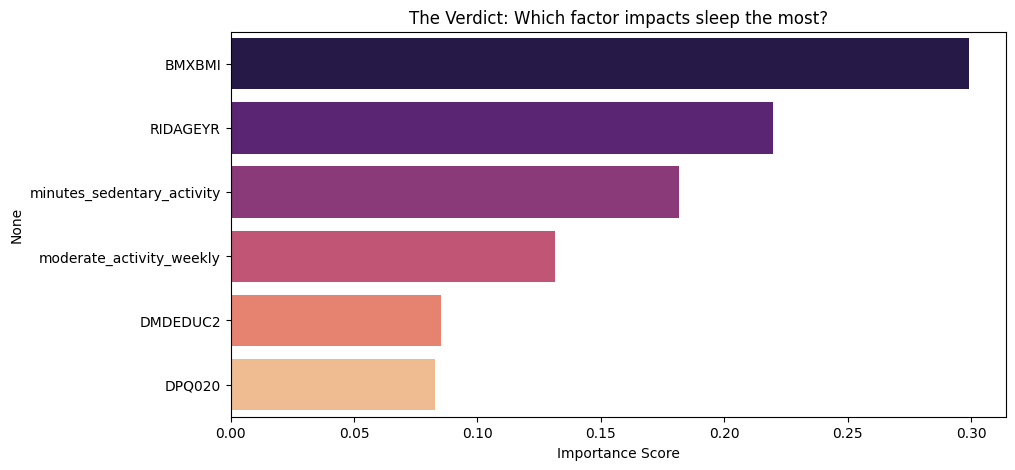

In [181]:
print("\n--- 3. Feature Importance Battle (Random Forest) ---")

df_ml = df_final[cols_to_analyze].dropna()
X = df_ml.drop(columns=['sleep_hours_weekly_aver'])
y = df_ml['sleep_hours_weekly_aver']


rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)


importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index, palette='magma', hue=importances.index, legend = False)
plt.title("The Verdict: Which factor impacts sleep the most?")
plt.xlabel("Importance Score")
plt.show()

# 4 Machine Learning